# Summary
In this Machine learning project our goal is to showcase the use of different data analyzing tools in order to create areained model
to recognize #TODO Keep writing

# Introduction
## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display
from project_supp import convert_column_to_num_month, month_num_season, month_int_to_str
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.animation as animation
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

import category_encoders as ce
import missingno as msno

# import country_converter as coco
# import plotly.graph_objects as go
# import cufflinks

## Import Data

In [2]:
df = pd.read_csv("Data/feature_data.csv")

## First look
Currently displayed are the first 10 rows of the data

In [3]:
df.head(10)

,Unnamed: 0,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
0,51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,...,0,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0
1,28536,3.0,2016,October,week_41,2,2,0.0,0,ESP,...,0,3.0,0.0,1.0,1,1.0,0.444719,2.343371,True,NaN
2,21745,NaN,2017,March,week_12,19,1,0.0,0,DEU,...,4,4.0,0.0,0.0,0,1.0,0.598733,2.498820,True,NaN
3,17502,153.0,2015,September,week_40,29,2,0.0,0,GBR,...,3,3.0,0.0,0.0,0,1.0,0.335675,12.411559,True,NaN
4,83295,33.0,2016,January,week_5,25,2,0.0,0,BRA,...,0,0.0,15.0,0.0,0,0.0,0.492874,5.743378,True,NaN
5,67872,50.0,2017,May,week_19,8,2,2.0,0,AGO,...,5,5.0,0.0,0.0,0,0.0,0.297551,7.234509,True,NaN
6,21763,NaN,2016,March,week_11,9,1,0.0,0,PRT,...,0,0.0,0.0,0.0,0,1.0,0.514393,2.490639,True,NaN
7,16156,72.0,2015,NaN,week_33,9,2,0.0,0,NaN,...,0,0.0,0.0,0.0,2,1.0,0.372214,8.449535,True,NaN
8,100645,180.0,2016,October,week_44,28,2,0.0,0,NaN,...,0,0.0,0.0,0.0,2,0.0,0.427402,13.497397,True,NaN
9,95004,280.0,2016,August,week_33,12,2,2.0,0,GBR,...,1,NaN,0.0,1.0,2,0.0,0.182388,16.723083,False,0.0


## Dataframe Info
As seen below this data has 33 features currently of different types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89542 entries, 0 to 89541
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           89542 non-null  int64  
 1   time_until_order     76861 non-null  float64
 2   order_year           89542 non-null  int64  
 3   order_month          86108 non-null  object 
 4   order_week           89542 non-null  object 
 5   order_day_of_month   89542 non-null  int64  
 6   adults               89542 non-null  int64  
 7   children             89538 non-null  float64
 8   babies               89542 non-null  int64  
 9   country              85201 non-null  object 
 10  order_type           89542 non-null  object 
 11  acquisition_channel  89542 non-null  object 
 12  prev_canceled        89542 non-null  int64  
 13  prev_not_canceled    89542 non-null  int64  
 14  changes              86065 non-null  float64
 15  deposit_type         80536 non-null 

In [5]:
df.describe()

,Unnamed: 0,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,...,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_13
count,89542.000000,76861.000000,89542.000000,89542.000000,89542.000000,89538.000000,89542.000000,89542.000000,89542.000000,86065.000000,...,89542.000000,89542.000000,85510.000000,85309.000000,85294.000000,89542.000000,85811.000000,86810.000000,84585.000000,5776.000000
mean,59716.762871,103.673879,2016.157658,15.828807,1.857497,0.103732,0.007896,0.087411,0.137701,0.223877,...,0.032231,0.989971,1.330944,2.339401,0.062607,0.571922,0.335691,0.427146,8.845679,0.365132
std,34495.242240,106.940156,0.707461,8.779753,0.565296,0.397797,0.095194,0.849799,1.496269,0.663361,...,0.176613,1.698086,1.879927,17.516854,0.243415,0.793567,0.472234,0.128140,5.236673,0.481509
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161008,0.038632,0.000000
25%,29838.250000,18.000000,2016.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328012,4.452191,0.000000
50%,59743.500000,69.000000,2016.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425622,8.422255,0.000000
75%,89610.500000,159.000000,2017.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.511077,12.712815,1.000000
max,119388.000000,737.000000,2017.000000,31.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,...,1.000000,9.000000,11.000000,391.000000,3.000000,5.000000,1.000000,0.907525,27.172399,1.000000


## Tidying the Data
In This section we won't begin "preprocessing", but
we will commit some minor changes in order to read the data properly.
### Changing Features to Numeric Value
In the beginning we would perform no changes to the data but tidying it

In [6]:
# Weeks and months
df["order_month"] = convert_column_to_num_month(df, "order_month")
df['order_week'] = df['order_week'].str.strip("week_").astype(int)
# Bol to int
df['anon_feat_12'] = df['anon_feat_12'].astype(int)

# Part 1: Exploration, Basic Hypothesis

## Histograms

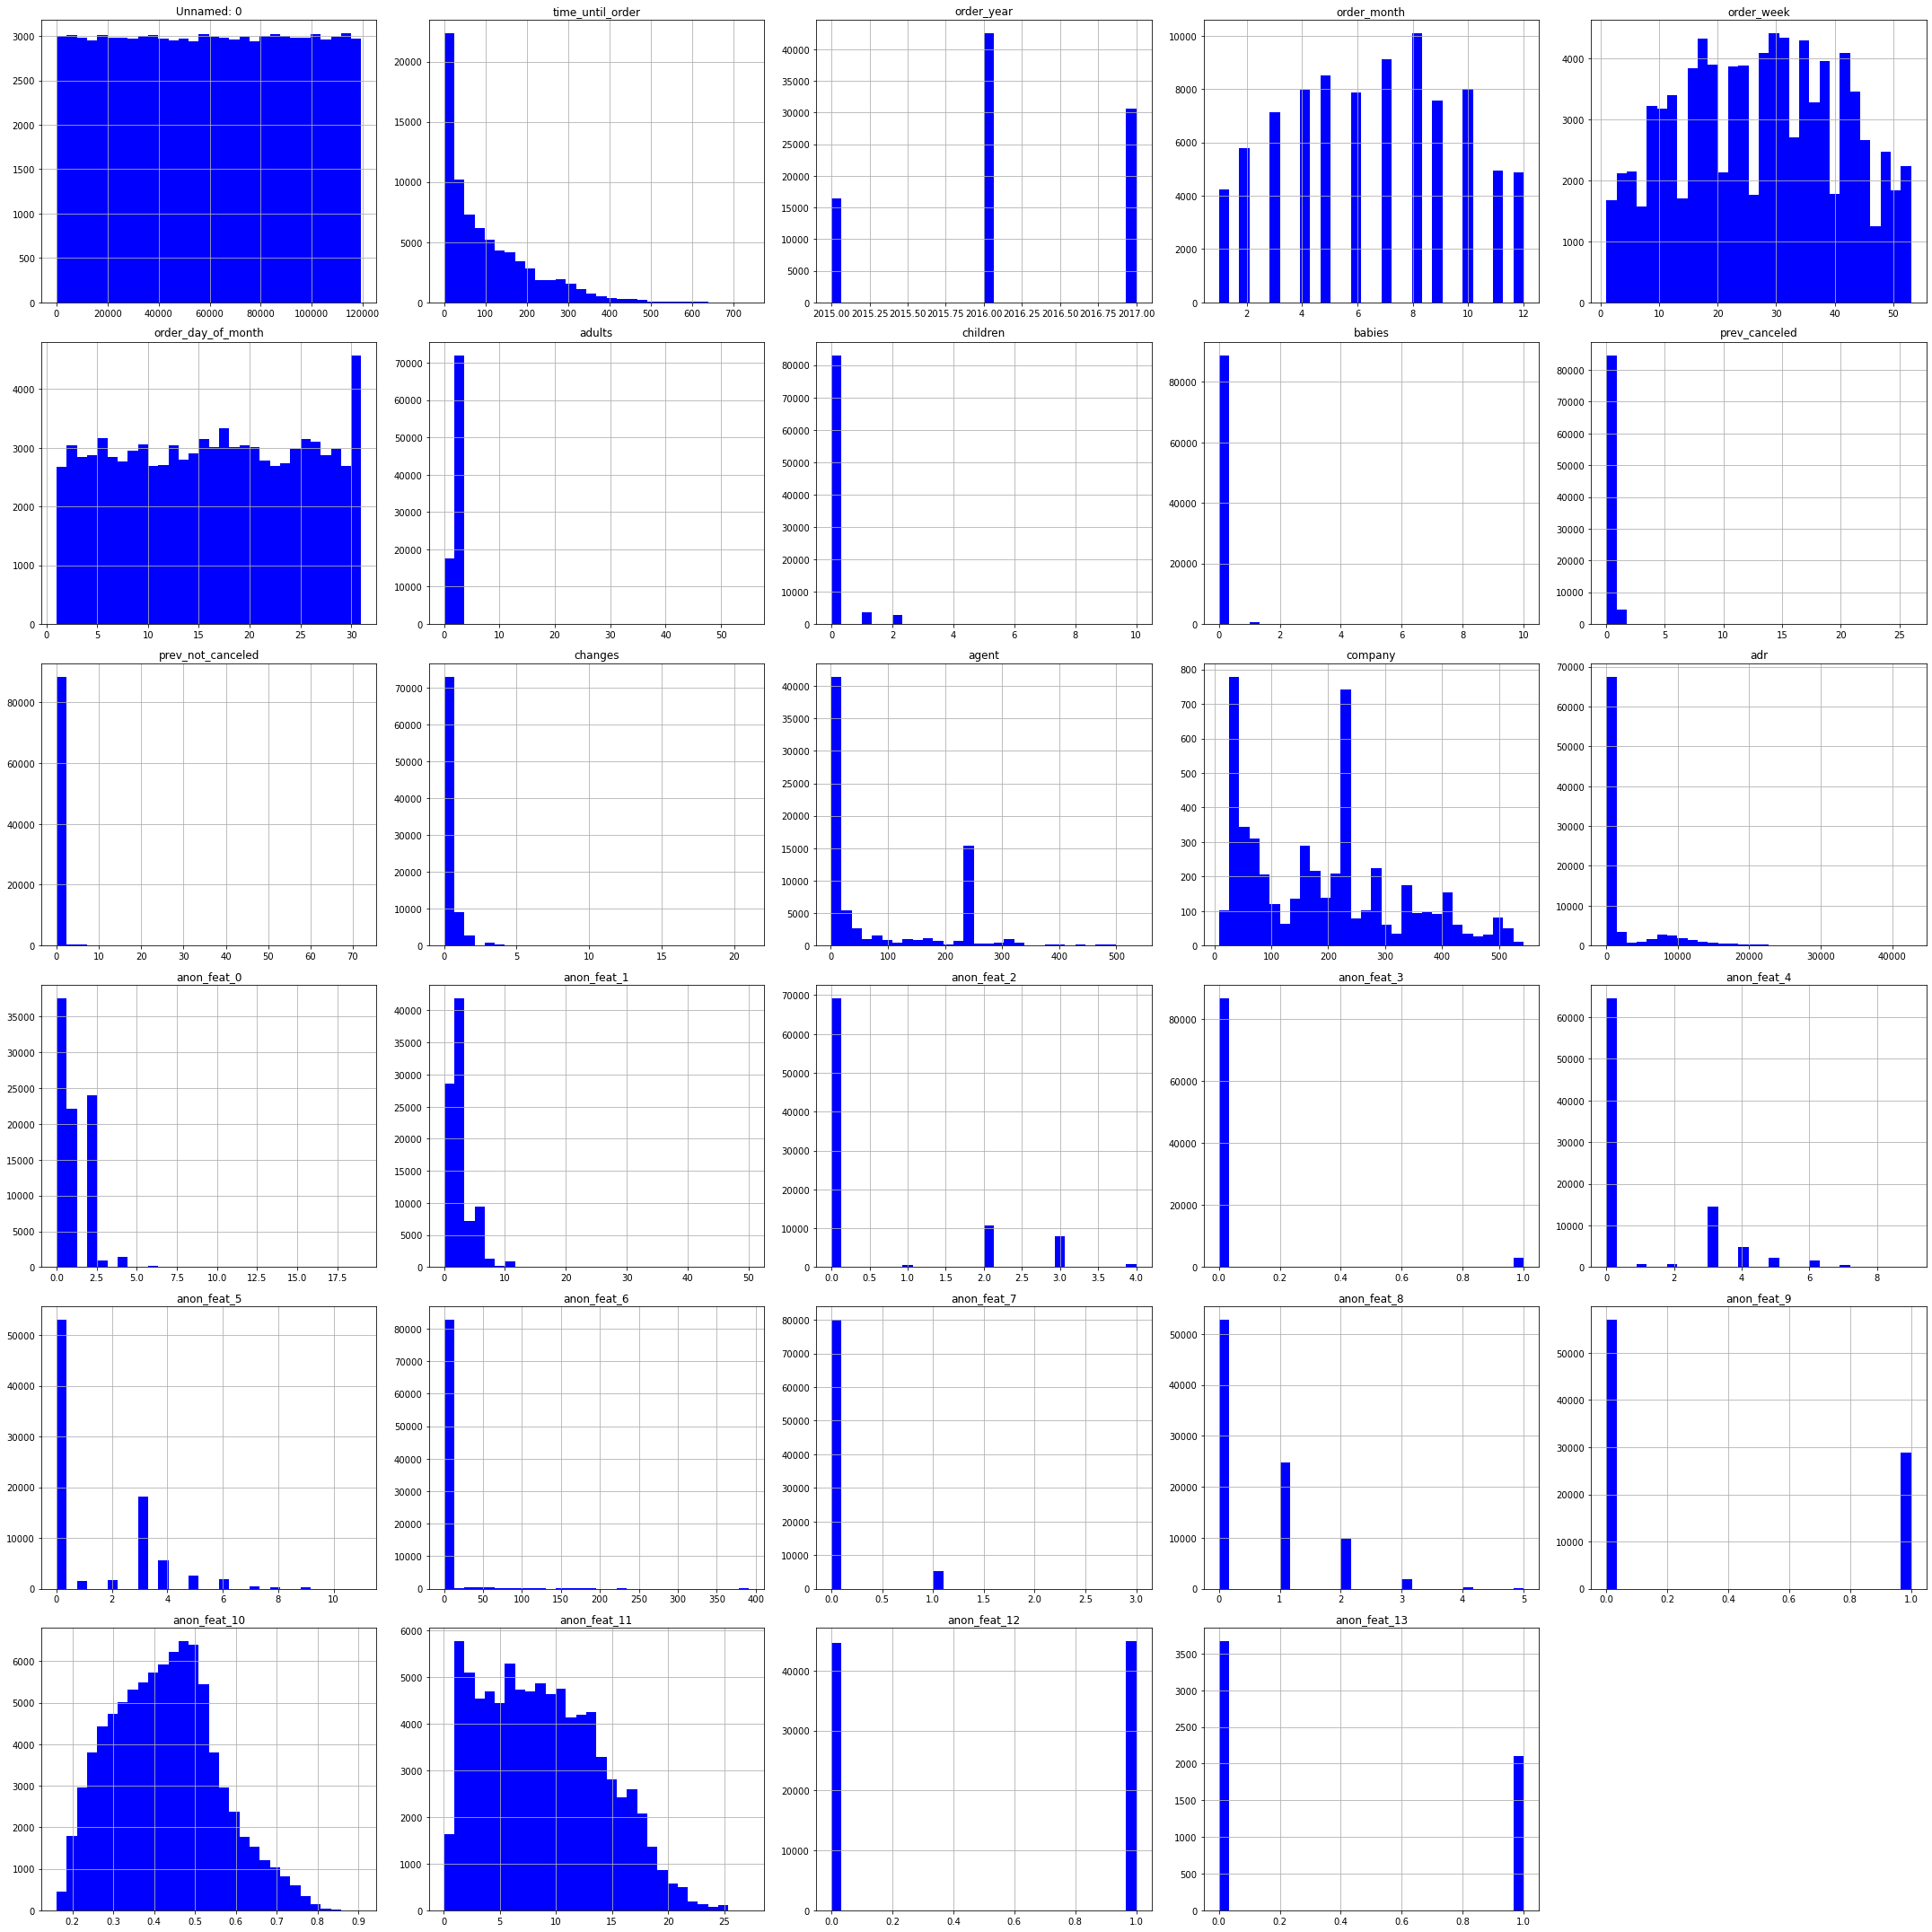

In [7]:
df.hist(figsize=(30,30), bins=30, color='blue')
plt.tight_layout()
plt.show()

## First Impression
### Correlation Matrix
This is a very first look over correlations. We would come back to this matrix later.

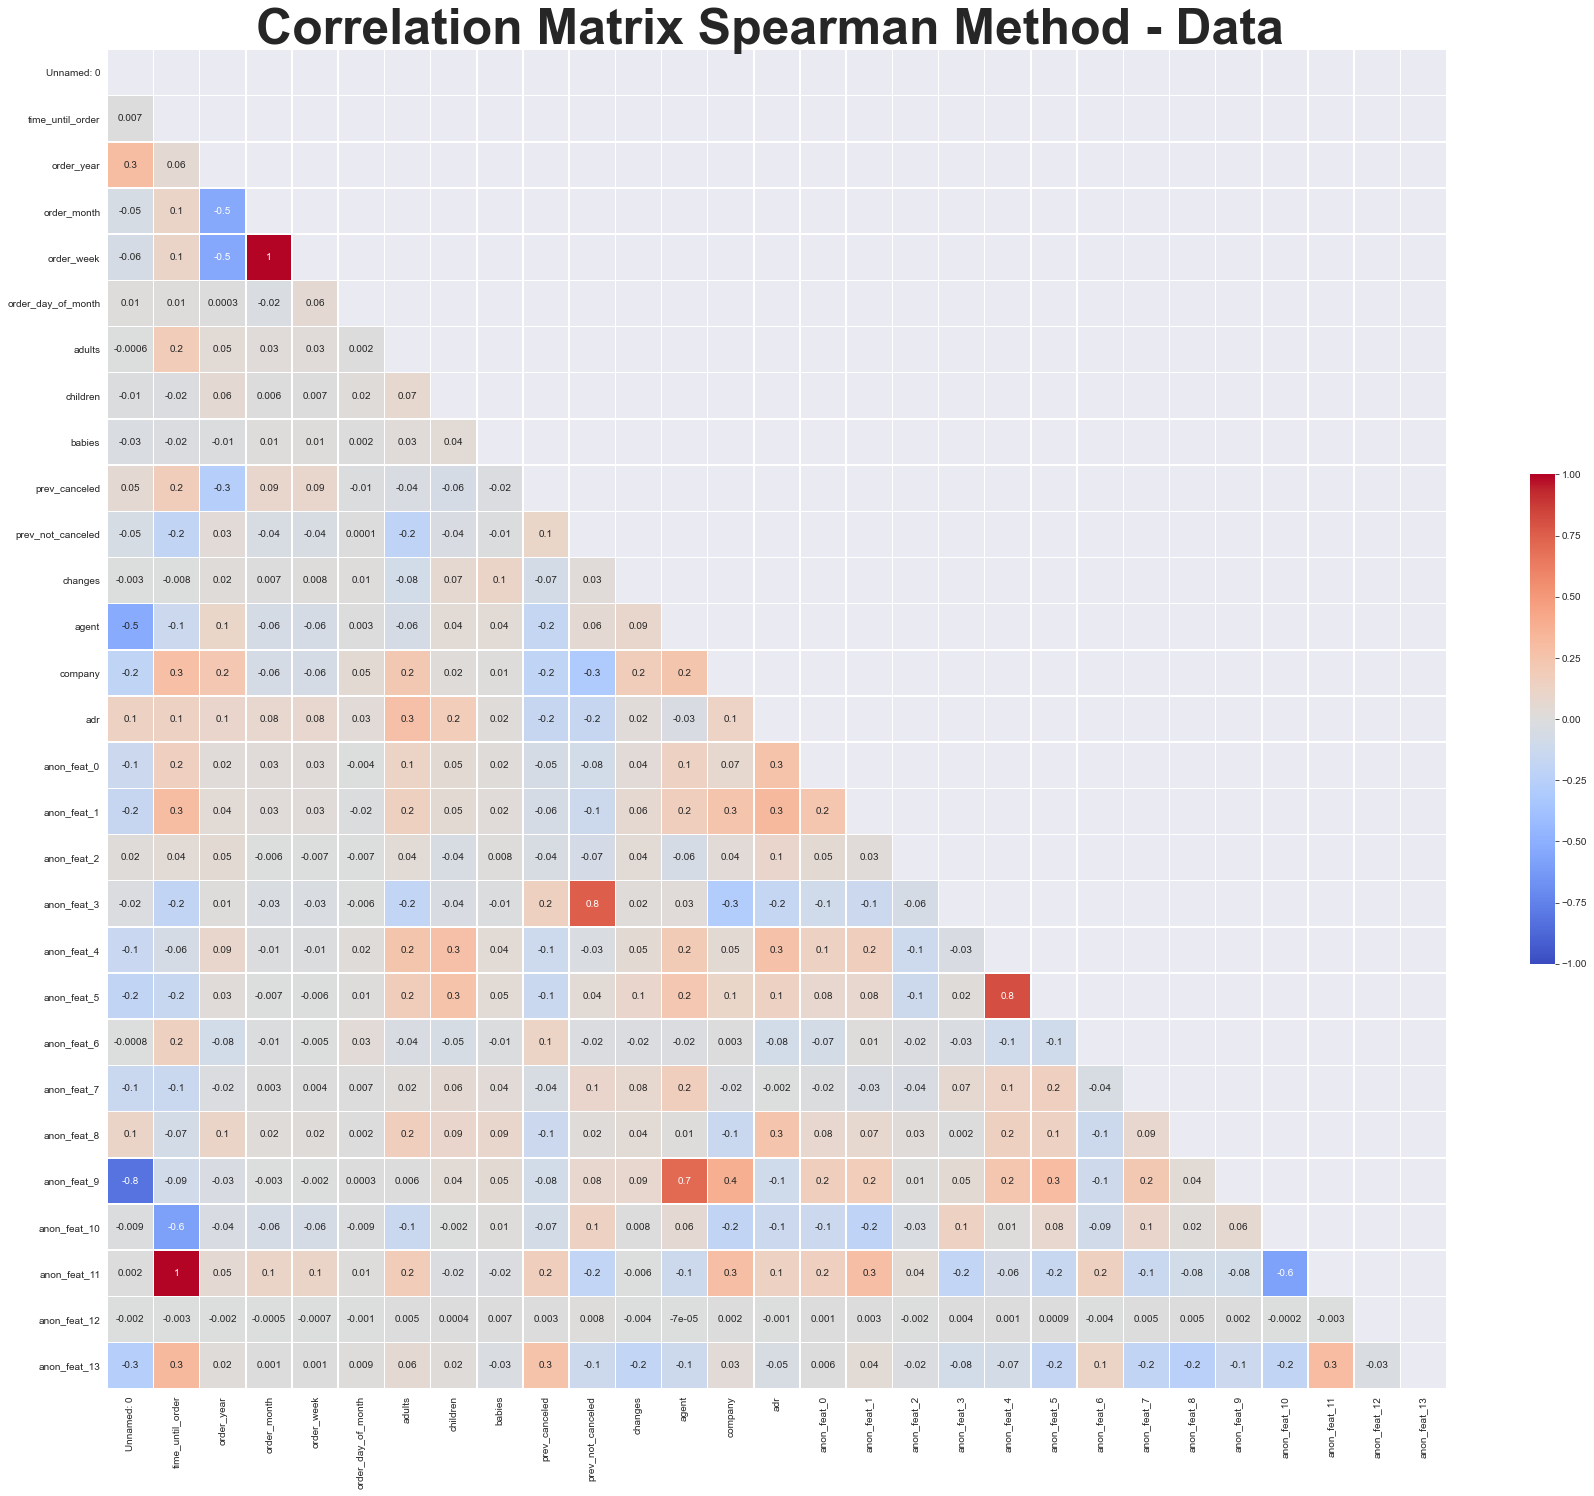

In [8]:
plt.figure(figsize=(30,30))
sns.set_style('darkgrid')
corr=df.corr(method='spearman')
mask_corr = np.triu(np.ones_like(corr, dtype=np.bool))
heat = sns.heatmap(corr, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'coolwarm', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix Spearman Method - Data ",size=50, weight='bold')
plt.show()

### Analyzing the Correlation Matrix
#### From the Heatmap
Those are the top correlating values, above 55% of correlation.

In [9]:
corr = corr[corr>=0.55]
corr = corr.abs()
corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
corr

time_until_order   anon_feat_11    0.999476
order_month        order_week      0.995450
anon_feat_4        anon_feat_5     0.813804
prev_not_canceled  anon_feat_3     0.755504
agent              anon_feat_9     0.713712
dtype: float64

We have recognized a few suggested correlations:
<li>strong positive correlation between
<li>anon feature 11 - time until order
<li>agent - anon feat 9
<li>anon feature 5 - anon feature 4
of course we can discard order month and order week.

## Creating New Features #TODO check if this legit
We have decided that a few manipulations can be done on the features from the begining.
We think some features can be discarded  completely, and some new ones should be created.
Features to drop:
<li>
<li>
<li>
Features to create:
<li> Season - by year's months.
<li>
<li>

In [10]:
# Creating seasons
seasons = {1: "Spring", 2: "Summer", 3:"Autumn", 4: "Winter"}
df['season'] = df['order_month'].apply(month_num_season)

In [11]:
# Creating "ordered in advance" feature

# df['ordered_in_advance'] = df['time_until_order'] > 250 #TODO That looks very smart to me, but maybe not here

In [12]:
# Creating "has_kids" feature
df['has_kids'] = df['children'] > 0
df['has_kids'] = df['has_kids'].astype(int)

In [13]:
# Early Predictions and Ideas
## Exploring New Features

##Visualisation of the Data
### Seasons vs number of orders

Text(0, 0.5, 'Count')

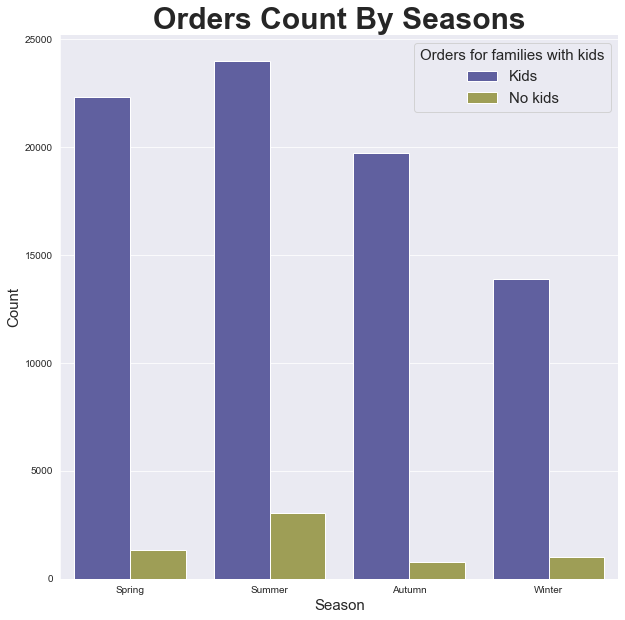

In [14]:
labels = [sea for sea in seasons.values()]
sns.set_style('darkgrid')
fig, bar = plt.subplots(figsize = (10,10))
bar = sns.countplot(x='season', hue='has_kids', data= df, palette='gist_stern',
                    orient = 'v')
bar.set_xticklabels(labels)
sns.despine()
bar.legend(title='Orders for families with kids', labels=['Kids', 'No kids']
           ,loc='upper right',
           fontsize=15, title_fontsize=15)
bar.set_title('Orders Count By Seasons', weight='bold', fontsize=30)
bar.set_xlabel('Season', fontsize=15)
bar.set_ylabel('Count', fontsize=15)

### Kids Number vs order month

Text(0, 0.5, '')

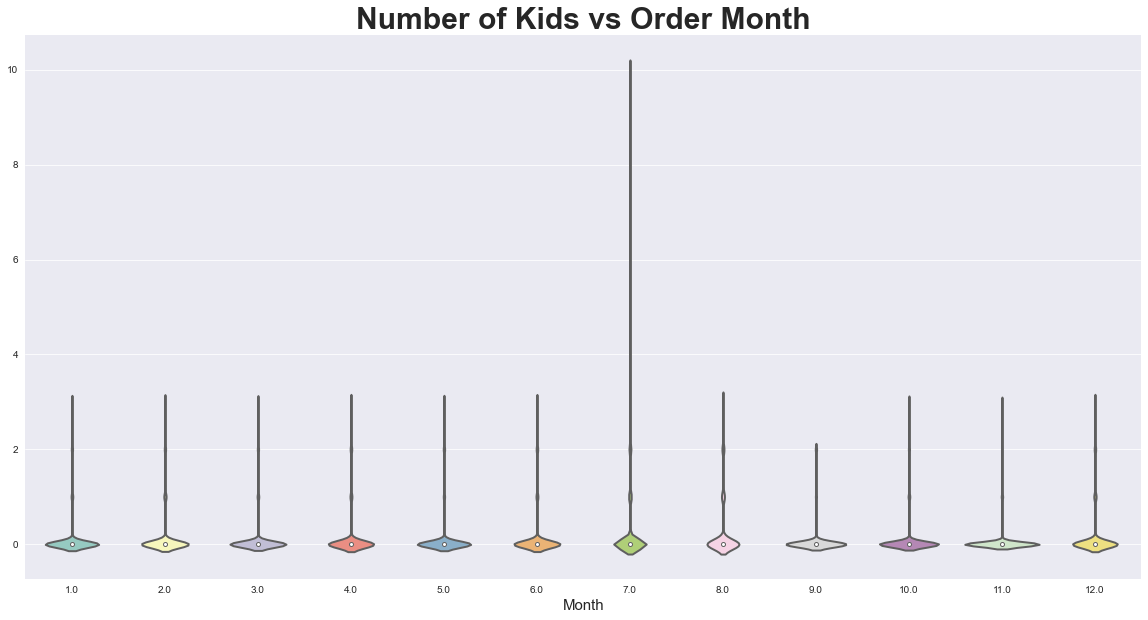

In [15]:
plt.figure(figsize=(20,10))
sns.violinplot(x='order_month', y ='children', data=df, palette="Set3", bw=.2,
               cut=2, linewidth=2, iner= 'box', split = True)
sns.despine(left=True)
plt.title('Number of Kids vs Order Month', weight='bold',
          fontsize=30)
plt.xlabel('Month', fontsize=15)
plt.ylabel('', fontsize=15)

### Kids Number vs Days Before Order

### Orders Count by Years

Text(0, 0.5, 'Count')

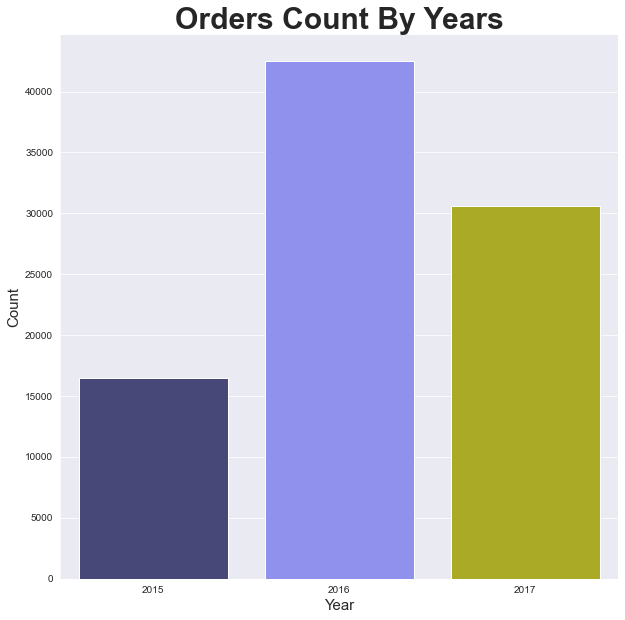

In [16]:
sns.set_style('darkgrid')
fig, bar = plt.subplots(figsize = (10,10))
bar = sns.countplot(x='order_year', data= df, palette='gist_stern',
                    orient = 'v')
sns.despine()
bar.set_title('Orders Count By Years', weight='bold', fontsize=30)
bar.set_xlabel('Year', fontsize=15)
bar.set_ylabel('Count', fontsize=15)

### anon_feat 12 Distribution

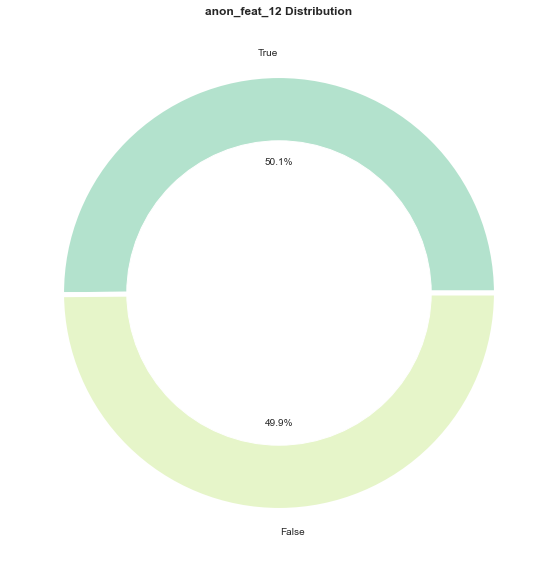

In [17]:
size = df['anon_feat_12'].value_counts()
plt.figure(figsize=(10,10))
cmap =plt.get_cmap("Pastel2")
labels= ['True', 'False']
colors = cmap(np.arange(3)*4)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, colors=colors, labels=labels,
        wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' },
        autopct="%.1f%%")
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('anon_feat_12 Distribution', weight='bold')
plt.show()

###  Prev Canceled Effect on Changes made

###  Top 10 Countries

Text(0, 0.5, 'Count')

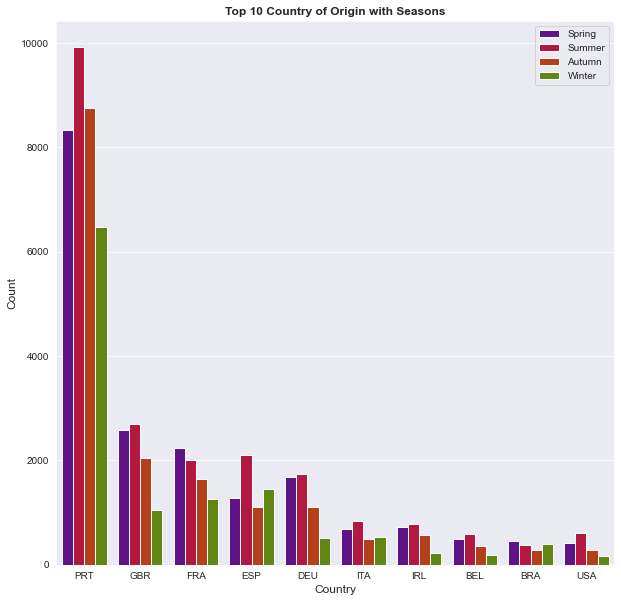

In [18]:
fig, bar = plt.subplots(figsize = (10,10))
sns.countplot(x='country',hue='season', data=df,
              order=pd.value_counts(df['country']).iloc[:10].index, palette="brg")
plt.title('Top 10 Country of Origin with Seasons', weight='bold')
plt.legend(labels=[season for season in seasons.values()])
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

###  PLACEHOLDER

### Order Type

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

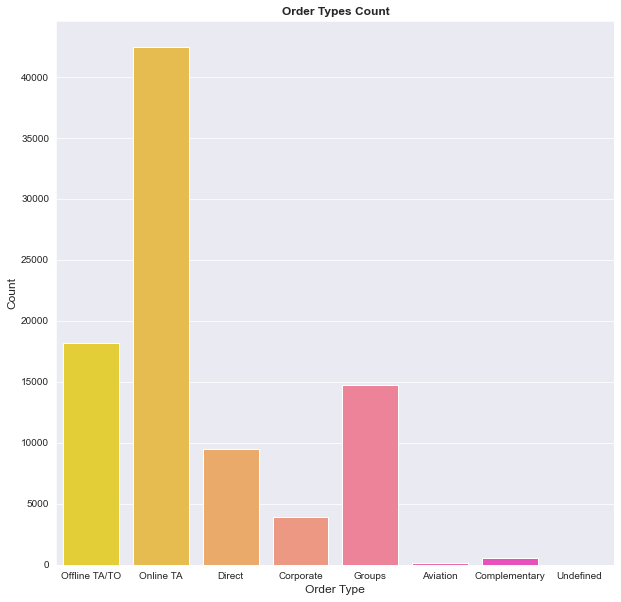

In [19]:
fig, bar = plt.subplots(figsize = (10,10))
sns.countplot(df['order_type'], palette='spring_r')
plt.title('Order Types Count', weight='bold')
plt.xlabel('Order Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Part 2: Preprocessing
## Answers for Part 2 questions
<br>
1. People who have deleted their orders more than 20 times.
  family with 10 kids that ordered a hotel
  -those cases are possible but they are outliers, therefore, we moved only the features that have more than 50% missing values
<br>
2. The data is not scaled.  scaling is essential for machine learning algorithms that calculate distances between data.
 If not scale, the feature with a higher value range starts dominating when calculating distances.
<br>
3. There are 253577 missing values in the dataframe. we chose to move only the features that with more than 50% missing values
have
<br>
4. The problem has more than 30  features for each row. big dimensionality can affect the predictions' accuracy.

## Feature Engineering

### Handling nan Data

First let's see how much is actually missing:

Text(0.5, 1.0, 'Missing Data')

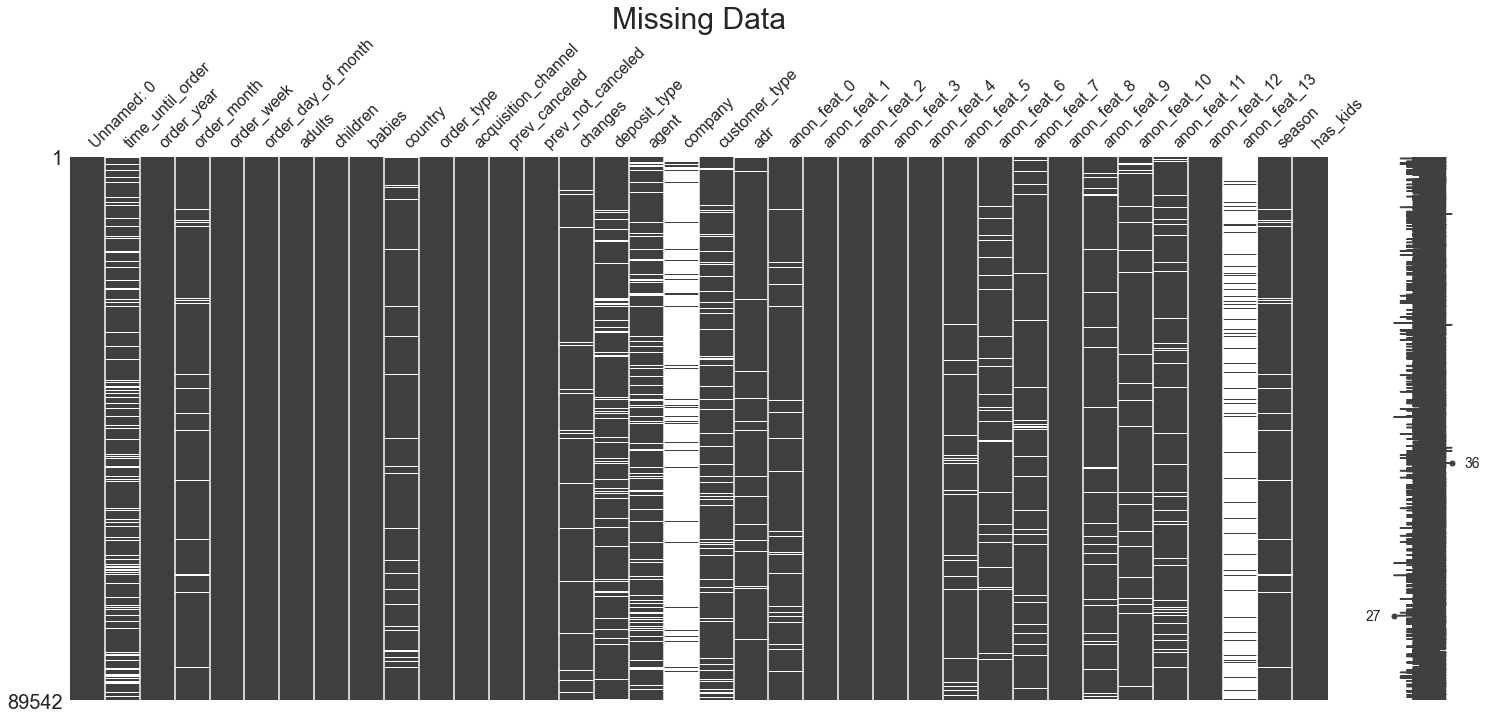

In [20]:
msno.matrix(df)
plt.title('Missing Data', fontsize=30)

We also chose to remove features of more than 50% nulls.

In [21]:
# drop columns of high "null percent"
drop_col = df.isnull().sum().divide(df.shape[0])
drop_col = list(drop_col[drop_col>0.5].index)
df = df.drop(drop_col, axis='columns')

After removing those problematic values we need to examine what is left:

In [22]:
df.isnull().sum().divide(df.shape[0]).round(8).astype(str) + "%"

Unnamed: 0                    0.0%
time_until_order       0.14162069%
order_year                    0.0%
order_month            0.03835072%
order_week                    0.0%
order_day_of_month            0.0%
adults                        0.0%
children                4.467e-05%
babies                        0.0%
country                0.04848004%
order_type                    0.0%
acquisition_channel           0.0%
prev_canceled                 0.0%
prev_not_canceled             0.0%
changes                0.03883094%
deposit_type            0.1005785%
agent                  0.13620424%
customer_type           0.1105068%
adr                    0.03331398%
anon_feat_0            0.03775882%
anon_feat_1                   0.0%
anon_feat_2                   0.0%
anon_feat_3                   0.0%
anon_feat_4                   0.0%
anon_feat_5            0.04502915%
anon_feat_6             0.0472739%
anon_feat_7            0.04744142%
anon_feat_8                   0.0%
anon_feat_9         

We can observe that the missing values are a very small percent of the data. We searched for the
most common values and used it to fill the missing

In [23]:
df.mode().head(1).squeeze()

Unnamed: 0                      0
time_until_order              0.0
order_year                 2016.0
order_month                   8.0
order_week                   33.0
order_day_of_month           17.0
adults                        2.0
children                      0.0
babies                        0.0
country                       PRT
order_type              Online TA
acquisition_channel         TA/TO
prev_canceled                 0.0
prev_not_canceled             0.0
changes                       0.0
deposit_type           No Deposit
agent                         9.0
customer_type           Transient
adr                          62.0
anon_feat_0                   0.0
anon_feat_1                   2.0
anon_feat_2                   0.0
anon_feat_3                   0.0
anon_feat_4                   0.0
anon_feat_5                   0.0
anon_feat_6                   0.0
anon_feat_7                   0.0
anon_feat_8                   0.0
anon_feat_9                   0.0
anon_feat_10  

Text(0.5, 1.0, 'Missing Data')

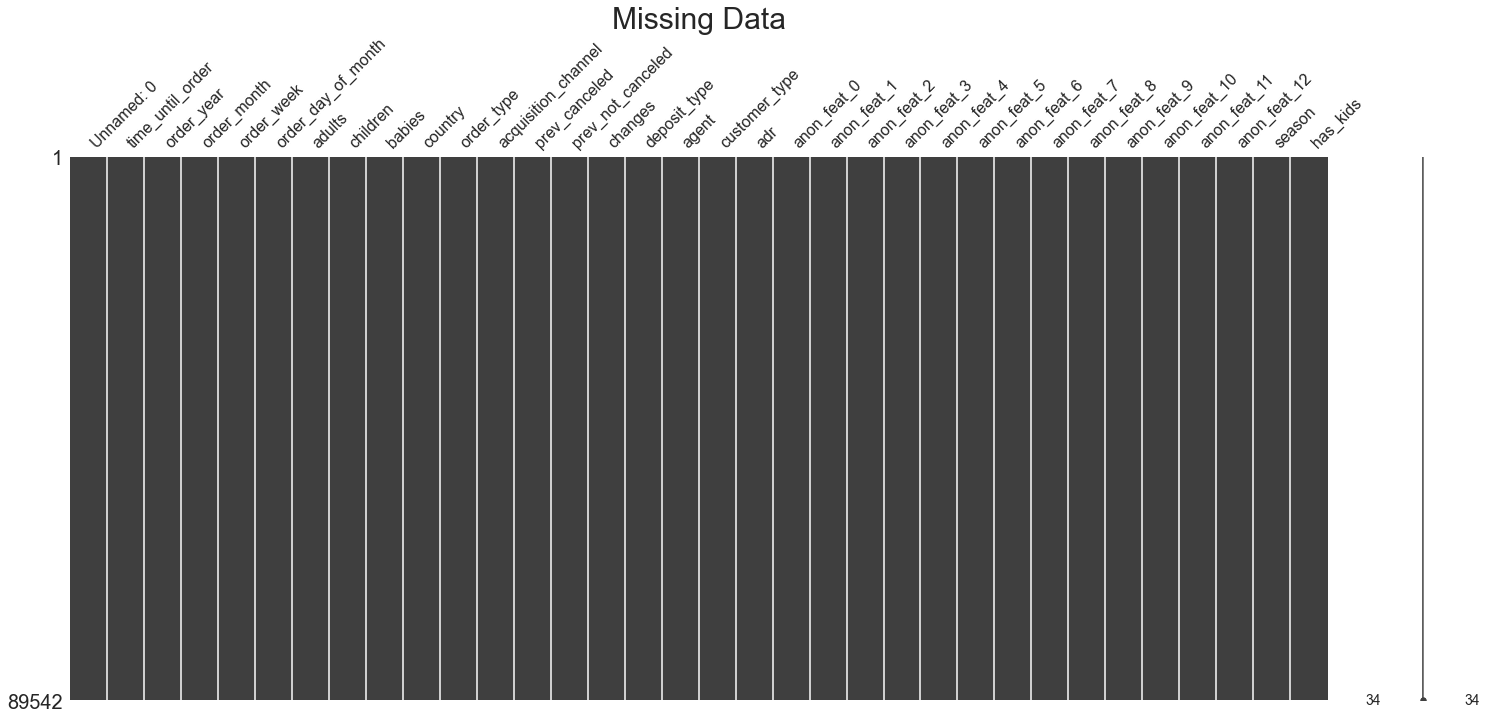

In [24]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for feature in df.columns:
    imp.fit(df[feature].values.reshape(-1,1))
    df[feature] = imp.transform(df[feature].values.reshape(-1,1))
msno.matrix(df)
plt.title('Missing Data', fontsize=30)

### Dealing with Categorical Data

In [25]:
## DUGRI we might choose later to discard all
#countries but for example portugal and the next top 10 - they consist of most of the data

# Categorical Data handling

categorical_cols = ['country', 'order_type', 'acquisition_channel',
                    'customer_type','deposit_type', 'prev_canceled',
                    'prev_not_canceled', 'anon_feat_0', 'anon_feat_3',
                    'anon_feat_9', 'anon_feat_12']
numerical_cols = ['Unnamed: 0', 'time_until_order', 'order_year',
                  'order_month', 'order_week', 'order_day_of_month',
                  'adults', 'children', 'babies',
                  'anon_feat_2', 'anon_feat_4', 'anon_feat_5',
                  'anon_feat_6', 'anon_feat_7', 'anon_feat_8',
                  'anon_feat_10', 'anon_feat_11', 'season', 'has_kids']
# Method 1: Encoding by base 8 (adds features)

# encoder= ce.BaseNEncoder(cols=categorical_cols, base=8) ## another method for categorizing, we need to choose
# df = encoder.fit_transform(df)

# Method 2: labelling

labelencoder = LabelEncoder()
for feature in categorical_cols:
    df[feature] = labelencoder.fit_transform(df[feature])


df_categorical = df[categorical_cols]
df_numerical = df[numerical_cols]

## Another Look on Correlation Matrices
### Categorical Features Correlation Matrix

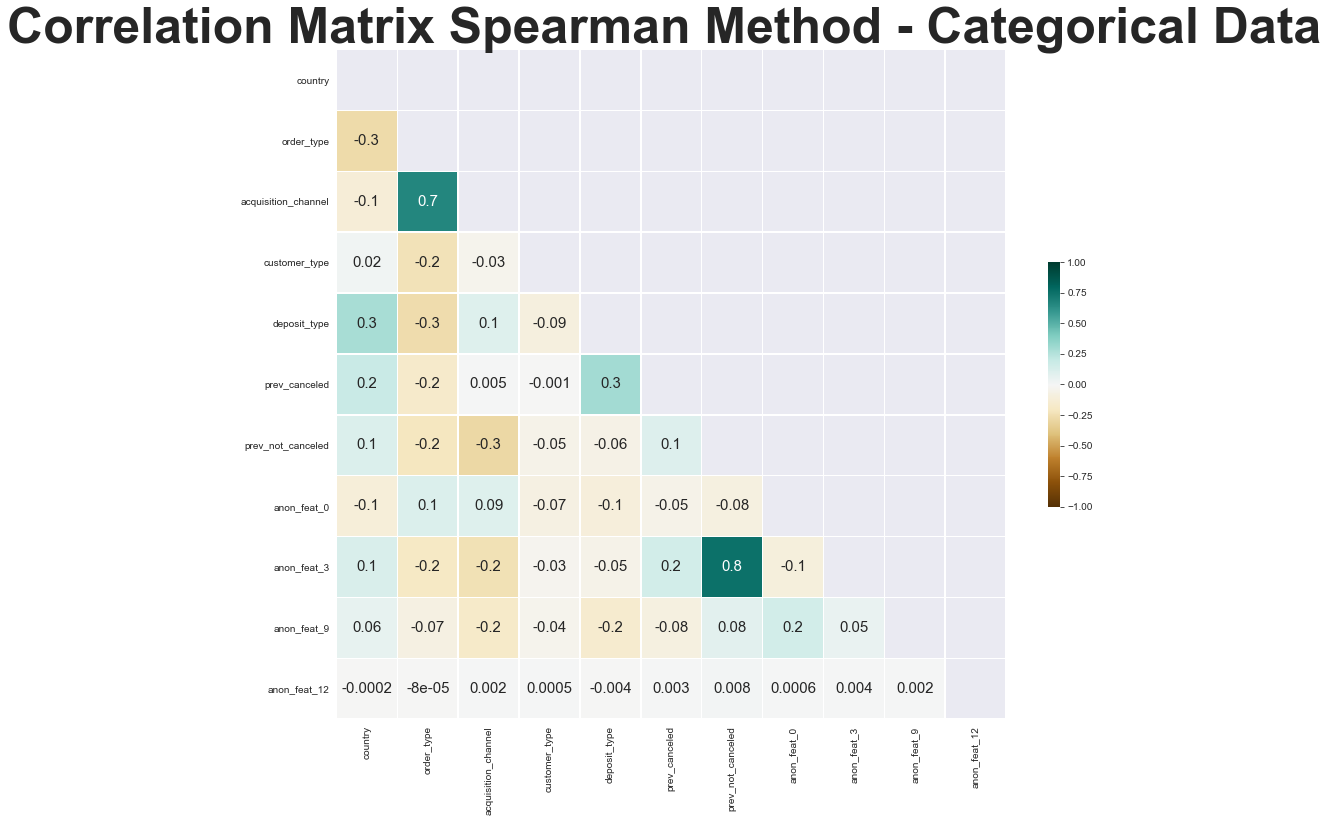

In [26]:
plt.figure(figsize=(15,15))
sns.set_style('darkgrid')
corr_cat = df_categorical.corr(method='spearman')
mask_corr = np.triu(np.ones_like(corr_cat, dtype=np.bool))
heat = sns.heatmap(corr_cat, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'BrBG', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":15},)
plt.title("Correlation Matrix Spearman Method - Categorical Data ",size=50, weight='bold')
plt.show()

#### Top Correlations for Categorical Values

In [27]:
corr_cat = corr_cat[corr_cat>=0.55].abs()
corr_cat = (corr_cat.where(np.triu(np.ones(corr_cat.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
corr_cat

prev_not_canceled  anon_feat_3            0.755504
order_type         acquisition_channel    0.668108
dtype: float64

### Numerical Features Correlation Matrix

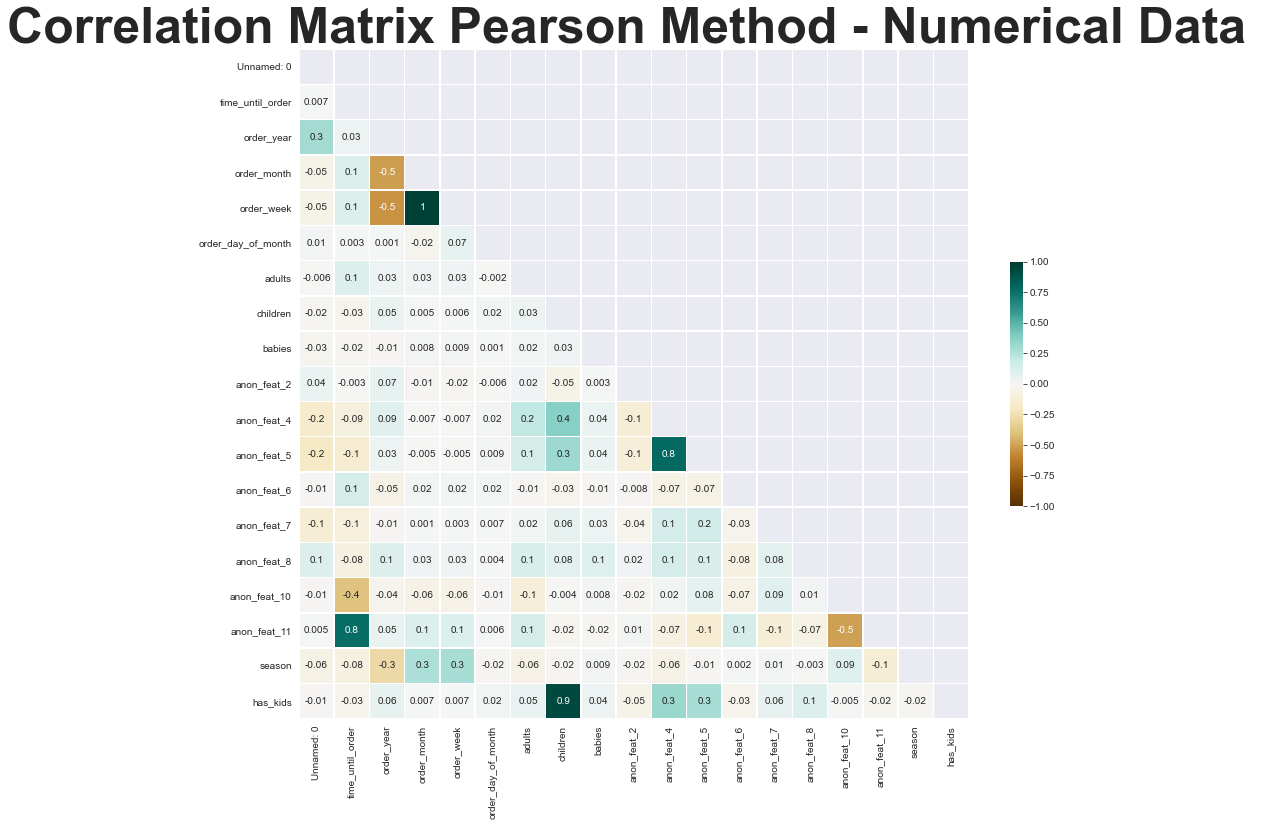

In [28]:
plt.figure(figsize=(15,15))
sns.set_style('darkgrid')
corr_num = df_numerical.corr(method='pearson')
mask_corr = np.triu(np.ones_like(corr_num, dtype=np.bool))
heat = sns.heatmap(corr_num, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'BrBG', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix Pearson Method - Numerical Data ",size=50, weight='bold')
plt.show()

#### Top Correlations for Numerical Values

In [29]:
corr_num = corr_num[corr_num>=0.55].abs()
corr_num = (corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
corr_num

order_month       order_week      0.971758
children          has_kids        0.935310
anon_feat_4       anon_feat_5     0.786298
time_until_order  anon_feat_11    0.768535
dtype: float64

## Choosing Features to Scale
After finishing all the feature engineering, just before splitting the data to
train sets, we can choose to scale only some features for the modeling.

In [30]:
# Remove Values here to remove from scaling

features_to_scale = [ 'time_until_order', 'order_year',
         'adults', 'country', 'order_type', 'acquisition_channel', 'prev_canceled',
       'prev_not_canceled', 'changes', 'deposit_type', 'agent',
       'customer_type', 'adr', 'anon_feat_0', 'anon_feat_1', 'anon_feat_2',
       'anon_feat_3', 'anon_feat_4', 'anon_feat_5', 'anon_feat_6',
       'anon_feat_7', 'anon_feat_8', 'anon_feat_9', 'anon_feat_10',
                      'anon_feat_12', 'season', 'has_kids']

features_dropped = ['Unnamed: 0','children', 'babies', 'order_week', 'order_month', 'order_day_of_month',
                    'anon_feat_11']

df = df.filter(features_to_scale, axis=1)

# Part 3: Modelling

## Splitting the Data
At this stage we would like to split the data before further manipulations are done.

In [31]:
# Loading te training Data

y= pd.read_csv('Example/label_data.csv')
y['cancelation'] = y["cancelation"].astype(int)
df.corrwith(y['cancelation'])

time_until_order       0.254488
order_year             0.014949
adults                 0.058103
country                0.258090
order_type             0.060234
acquisition_channel    0.167902
prev_canceled          0.152618
prev_not_canceled     -0.060920
changes               -0.141447
deposit_type           0.440889
agent                 -0.048683
customer_type         -0.064868
adr                   -0.069212
anon_feat_0           -0.000468
anon_feat_1            0.026997
anon_feat_2           -0.016972
anon_feat_3           -0.085612
anon_feat_4           -0.060772
anon_feat_5           -0.170461
anon_feat_6            0.056846
anon_feat_7           -0.192378
anon_feat_8           -0.233985
anon_feat_9           -0.131728
anon_feat_10          -0.188722
anon_feat_12          -0.004417
season                -0.029667
has_kids              -0.004485
dtype: float64

In [32]:
#Splitting the data

X_train, X_test, y_train, y_test = \
    train_test_split(df, y, test_size=0.33, random_state=42)

modeling_sets = [X_train, X_test, y_train, y_test]

## Feature Scoring

Feature 0: 4049.253770
Feature 1: 9.692792
Feature 2: 188.135970
Feature 3: 4300.518915
Feature 4: 206.746061
Feature 5: 1682.877145
Feature 6: 1406.151727
Feature 7: 226.813627
Feature 8: 1188.243435
Feature 9: 14522.004161
Feature 10: 137.173014
Feature 11: 243.641128
Feature 12: 298.262351
Feature 13: 0.007525
Feature 14: 42.862953
Feature 15: 18.650223
Feature 16: 473.178984
Feature 17: 225.434321
Feature 18: 1790.315089
Feature 19: 179.180629
Feature 20: 2330.700576
Feature 21: 3541.806661
Feature 22: 1064.393395
Feature 23: 2157.202283
Feature 24: 2.783181
Feature 25: 61.731433
Feature 26: 1.604620


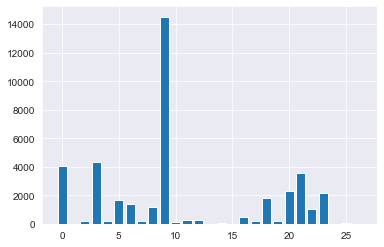

In [33]:
# feature selection
def select_features(X_train, y_train, X_test):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train['cancelation'], X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Scaling the Data

In [34]:
standardScalerX = StandardScaler()
X_train = standardScalerX.fit_transform(X_train)
X_test = standardScalerX.fit_transform(X_test)

## Exploring the Train Data Correlations with y

## PCA Testing - Dimensionality

In [ ]:
pca = PCA()
data_for_PCA = (X_train-X_train.mean()/(X_train.std()))
# drop = [9, 15, 20, 23] # For case of using category encoding
# data_for_PCA.drop(data_for_PCA.columns[drop], axis='columns', inplace=True) # For case of using category encoding
X_train_pca = pca.fit_transform(data_for_PCA)

Text(0.5, 0, 'Dimensions')

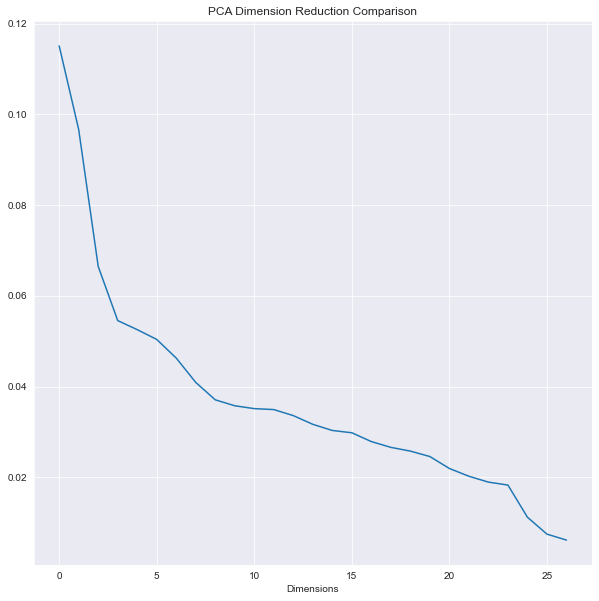

In [36]:
#Show the PCA comparison

plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_)
plt.title('PCA Dimension Reduction Comparison')
plt.xlabel('Dimensions')

## Classifiers
We are going to run the following classifiers:

In [37]:
clfs = [LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

Now we are going to train them naively and see what classifier gives us the best AUC and accuracy score

LogisticRegression()


TypeError: not all arguments converted during string formatting

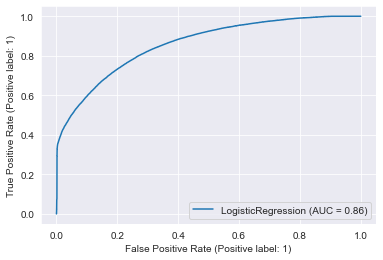

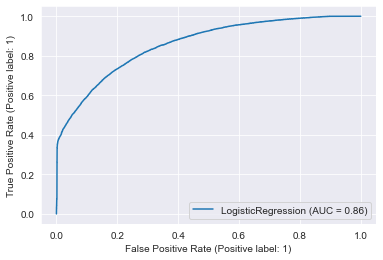

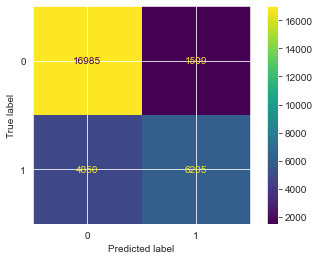

In [48]:
for clf in clfs:
    print(clf)
    clf.fit(X_train, y_train['cancelation'])
    plot_roc_curve(clf,X_train, y_train['cancelation'])
    plot_roc_curve(clf,X_test, y_test['cancelation'])
    plot_confusion_matrix(clf,X_test, y_test['cancelation'] )
    print("Test accuracy_score" % (clf.predict(X_test), y_test['cancelation']))
    plt.show()

we chose the model with the highest AUC score which is the Random Forest classifier

# Hyperparameter tuning for Random Forest classifier

we can see that the optimal number of features is 27, meaning we need to use all our features. Now we are going to tune the the hyperparameter for our model.

In [ ]:
# define number of features to evaluate
num_features = [i+1 for i in range(X_train.shape[1])]
# enumerate each number of features
results = list()

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


for k in num_features:
    # create pipeline
    model = RandomForestClassifier()
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('rf', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X_train, y_train['cancelation'])
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

>1 0.739 (0.004)
>2 0.741 (0.004)
>3 0.762 (0.005)


In [40]:
from sklearn.model_selection import GridSearchCV
import numpy as np

max_features_range = np.arange(3,7,1)
n_estimators_range = np.arange(100,220,20)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', verbose=10)

In [41]:
grid.fit(X_train, y_train['cancelation'])

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_features=3, n_estimators=100...........................
[CV 1/5; 1/24] END .........max_features=3, n_estimators=100; total time=   4.2s
[CV 2/5; 1/24] START max_features=3, n_estimators=100...........................
[CV 2/5; 1/24] END .........max_features=3, n_estimators=100; total time=   4.2s
[CV 3/5; 1/24] START max_features=3, n_estimators=100...........................
[CV 3/5; 1/24] END .........max_features=3, n_estimators=100; total time=   4.2s
[CV 4/5; 1/24] START max_features=3, n_estimators=100...........................
[CV 4/5; 1/24] END .........max_features=3, n_estimators=100; total time=   4.1s
[CV 5/5; 1/24] START max_features=3, n_estimators=100...........................
[CV 5/5; 1/24] END .........max_features=3, n_estimators=100; total time=   4.1s
[CV 1/5; 2/24] START max_features=3, n_estimators=120...........................
[CV 1/5; 2/24] END .........max_features=3, n_e

In [45]:
clf = RandomForestClassifier(n_estimators= 180, max_features = 5, verbose = 10)
clf.fit(X_train, y_train['cancelation'])
accuracy_score(y_test['cancelation'], clf.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 180
building tree 2 of 180


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 180
building tree 4 of 180


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 180
building tree 6 of 180


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


building tree 7 of 180
building tree 8 of 180


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s


building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    2.6s finished


0.8683204169345833